[View in Colaboratory](https://colab.research.google.com/github/opooladz/ece_210_final_project/blob/master/210_final_project.ipynb)

In [0]:
# Import Libs 
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt
import scipy.special
import scipy.io as sio
import math

# Reloading any code written in external .py files.
%load_ext autoreload
%autoreload 2

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, AveragePooling2D, MaxPooling2D, Dropout, BatchNormalization
import keras
from sklearn import model_selection
from sklearn import svm
from keras.optimizers import Adam


In [0]:
# Comms Stuff Will add more later
def qammod(m,width):
  #y = np.random.randint(m,size=dims)
  y = (np.arange(m)*np.ones((width,m))).T
  if(np.all(y>=m)):
    print('qammod: all elements of X must be in range [0,M-1]')
  
  if (~np.all(y == np.fix(y) ) ):
    print("qammod: all elements of X must be integers");
  
  c = np.sqrt(m);
  if( ~(np.all(c == np.fix(c)) and np.all(np.math.log(c, 2) == np.fix(np.math.log(c, 2))) ) ):
    print("qammod: M must be a square of a power of 2");
  
  b = -2*np.fmod(y,c) + c - 1.;
  a = 2*np.floor(y *1./c) - c + 1.;
  # x = a + 1.*1j*b
  # lets hold x in a np array([real,imag])
  x = np.array([a,1.*b]).transpose(2,1,0)
  return [x , y]

def channel(m,width,Noise,SNRdB):
  [x,y] = qammod(m,width)
  SNR = 10**(SNRdB/10)
  sym_noise_pow = np.var(x)/SNR
  sym_noise_scale_fact = np.sqrt(sym_noise_pow)
  if(Noise):
    AWGN = sym_noise_scale_fact*np.random.normal( size=(width,m,2)) 
    x = x + AWGN
  return [x , y]
data={}
def generateData(m,samples,Noise,SNRdB):
  [data['x_train'],data['y_train']] = channel(m=m,width=samples,Noise=Noise,SNRdB=SNRdB)
  #valsize = [int(x*0.1) for x in range(width)]
  [data['x_val'],data['y_val']] = channel(m=m,width=int(samples*0.1),Noise= Noise,SNRdB=SNRdB)
  [data['x_test'],data['y_test']] = channel(m=m,width=samples,Noise=Noise,SNRdB=SNRdB)

In [0]:
# Keras try model 
def try_model(model, data, name, epochs=25, verbose=1):  
  model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

  model.summary()  
  history = model.fit(data['X_train'], data['y_train'], 
            epochs=epochs, batch_size=64, verbose=verbose, 
            validation_data=(data['X_val'], data['y_val']))  
  score = model.evaluate(data['X_test'], data['y_test'])
  print('Test accuracy: {}'.format(score))
  
#   out_path = 'serialized_models/{}.h5'.format(name)  
#   model.save(out_path)
  
#   with open('serialized_models/{}_history.pickle'.format(name), 'wb') as handle:
#     pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
  return history

In [182]:
# Generates 16-QAM model with AWGN
generateData(m=16,samples=1000,Noise=1,SNRdB = 20)
print(data['x_train'].shape) # data
print(data['y_train'].shape) # labels 
# Our data is complex so I just made a len 2 list of real numbers.
# This way we can run it thought a conv net and keep spatial features
# Just so y'all can see the data  
print(data['x_train'][:,0,:])



(1000, 16, 2)
(16, 1000)
[[-3.17492713  2.72493032]
 [-3.01376188  3.03051815]
 [-2.71958871  2.65457909]
 ...
 [-2.79506679  2.73563195]
 [-2.7181831   2.8448414 ]
 [-3.34920229  2.83804038]]


Text(0.5,1,'16-QAM Mod')

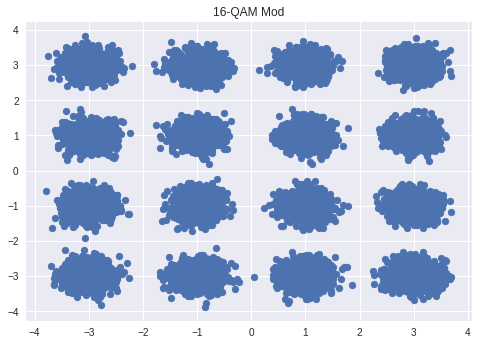

In [184]:
# Visulizing the data
# clearly we have 16 classes
# Right now this should be simple because I have not added any rayleigh fading 
# Lets get this to work and I'll keep updating the comms stuff
tmp = data['x_train'].T
plt.scatter(tmp[0],tmp[1])
plt.title('16-QAM Mod')

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Conv1D, Conv2D, Flatten, AveragePooling1D, MaxPooling2D, Dropout, BatchNormalization
from keras.layers import Reshape, Permute
from keras import regularizers
import keras

shallow_net = Sequential([
    Conv1D(filters = 40, kernel_size =(10), input_shape=(1000,1), activation='elu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    AveragePooling1D(pool_size=4, strides=2),  
    Flatten(),
    BatchNormalization(),
    Dropout(rate=.7),
    Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
])

try_model(shallow_net, data, 'shallow_net', epochs=100)

In [95]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, AveragePooling2D, MaxPooling2D, Dropout, BatchNormalization
from keras.layers import Reshape, Permute
from keras import regularizers
import keras

shallow_net = Sequential([
    Conv1D(filters = 40, kernel_size =(1, 10), input_shape=(100, 100, 1), activation='elu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    AveragePooling2D(pool_size=(1, 75), strides=(1, 30)),  
    Flatten(),
    BatchNormalization(),
    Dropout(rate=.7),
    Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
])

try_model(shallow_net, data, 'shallow_net', epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 991, 40)           440       
_________________________________________________________________
batch_normalization_51 (Batc (None, 991, 40)           160       
_________________________________________________________________
average_pooling1d_9 (Average (None, 494, 40)           0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 19760)             0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 19760)             79040     
_________________________________________________________________
dropout_20 (Dropout)         (None, 19760)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 79044     
Total para

ValueError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


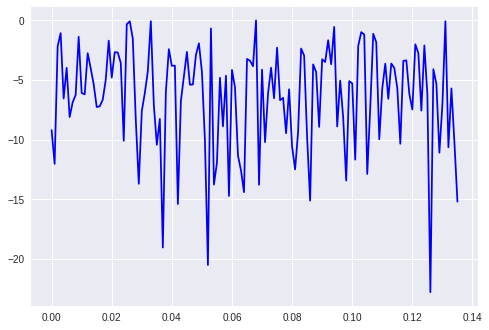

Text(0.5,1,'Rayleigh Fading')

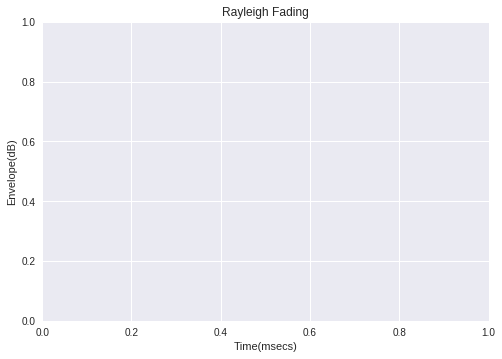

In [81]:
from numpy import sqrt
from numpy.random import randn
import numpy as np
import matplotlib.pyplot as plt

N=20;
fm=70.0;
df=(2*fm)/(N-1);
fs=1000;
M=round(fs/df);
T=1/df;
Ts=1/fs;                                

# Generating first Gaussian RV set
g=randn(int(N/2))+1j*randn(int(N/2))
gc=np.conj(g)
gcr=gc[::-1]
g1=np.concatenate((gcr,g),axis=0)


# Generating second Gaussian RV set
g=randn(int(N/2))+1j*randn(int(N/2))
gc=np.conj(g)
gcr=gc[::-1]
g2=np.concatenate((gcr,g),axis=0)

# Generating the Doppler Spectrum
f=np.arange(-fm, fm+df, df)
S=1.5/(np.pi*fm*sqrt(1-(f/fm)**2))
S[0]=2*S[1]-S[2]
S[-1]=2*S[-2]-S[-3] 

# Shaping the RV sequence g1 and taking IFFT
X=g1*sqrt(S);
X=np.concatenate((np.zeros(int((M-N)/2)), X), axis=0)
X=np.concatenate((X, np.zeros(int((M-N)/2))), axis=0)
x=np.abs(np.fft.ifft(X))                             

# Shaping the RV sequence g2 and taking IFFT 
Y=g2*sqrt(S)
Y=np.concatenate((np.zeros(int((M-N)/2)), Y), axis=0)
Y=np.concatenate((Y, np.zeros(int((M-N)/2))), axis=0)
y=np.abs(np.fft.ifft(Y))

# Generating complex envelope
z=x+1j*y
AWGN = np.random.normal(0,1,136)
zdirty = z + AWGN
r=np.abs(zdirty)



# Plotting the envelope in the time domain 
t=np.arange(0, T, Ts)
plt.plot(t, 10*np.log10(r/np.max(r)),'b')
plt.show()
plt.xlabel('Time(msecs)')
plt.ylabel('Envelope(dB)')
plt.grid(True)
plt.title('Rayleigh Fading')

In [46]:
np.random.rand(3, 3)

array([[0.10482177, 0.66860579, 0.47763953],
       [0.92379003, 0.83097422, 0.48872233],
       [0.65505026, 0.43900416, 0.16909601]])

In [79]:
z.shape

(136,)

In [78]:
AWGN.shape

(100,)